In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import numpy as np
from IPython.display import clear_output

from darts import TimeSeries
from darts.models import RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape

In [16]:
fengqiao = pd.read_csv('../data/intermediate/fengqiao_integrated_model.csv', index_col=0)
mete = pd.read_csv('../data/intermediate/mete_processed.csv', index_col=0)
precip = fengqiao['precipitation']
runoff = fengqiao['calculate_runoff']
discharge = fengqiao['discharge']
T2M_MAX = mete['T2M_MAX']
T2M_MIN = mete['T2M_MIN']
RH2M = mete['RH2M']
ALLSKY_SFC_SW_DWN = mete['ALLSKY_SFC_SW_DWN']
WS2M = mete['WS2M']
PS = mete['PS']
T2M = mete['T2M']
ETo_PM = mete['ETo_PM']
ETo_HS = mete['ETo_HS']

df = pd.DataFrame({
    'precip': precip,
    'runoff': runoff,
    'discharge': discharge
})
df.index = pd.to_datetime(df.index)

水文模型已经将discharge的相关性处理到了0.53左右，后面需要使用深度学习模型进一步提高相关性。这个方法可以归纳至physics-informed machine learning。

物理信息机器学习（Physics-informed machine learning）是一种新兴的研究领域，它试图将物理学的先验知识融入到机器学习模型中，以提高预测的准确性和可解释性。在水文学中，这通常涉及到将水文模型的输出作为机器学习模型的输入或特征。

在你的情况下，你可以考虑使用深度学习模型，如长短期记忆网络（LSTM）或卷积神经网络（CNN），因为它们在处理时间序列数据方面表现出色。你可以将integrated_model的输出（如runoff）以及其他相关特征（如降雨量、温度等）作为模型的输入，预测未来的discharge。

首先为了检验这套方法论的正确性，我们首先采用随机森林模型进行训练，测试有runoff和没有runoff对于预测结果的区别。

# Model training

## Without runoff feature

In [19]:
features = df.drop(['discharge','runoff'], axis=1)
target = df['discharge']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [20]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Squared Error:', mse)
print('R2 Score:', r2)

Mean Squared Error: 516.3490488710485
R2 Score: 0.0373201978004265


## With runoff feature   

In [21]:
features = df.drop(['discharge'], axis=1)
target = df['discharge']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [22]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print('Mean Squared Error:', mse)
print('R2 Score:', r2)

Mean Squared Error: 98.6661334484312
R2 Score: 0.8160471215360882


In [6]:
# 保存模型
import pickle
with open('model/rf_model.pkl', 'wb') as f:
    pickle.dump(model, f)

有runoff和无runoff的R2 Score结果区别巨大，这充分说明了将水文原理作为先验知识输入到机器学习模型中，可以提高预测的准确性和可解释性。当前采用了比较简单的融合方式，将水文模型的输出作为机器学习模型的输入或者特征。下面我会依据有runoff的模型进行系统性的分析。

# Model Evaluation

### Image

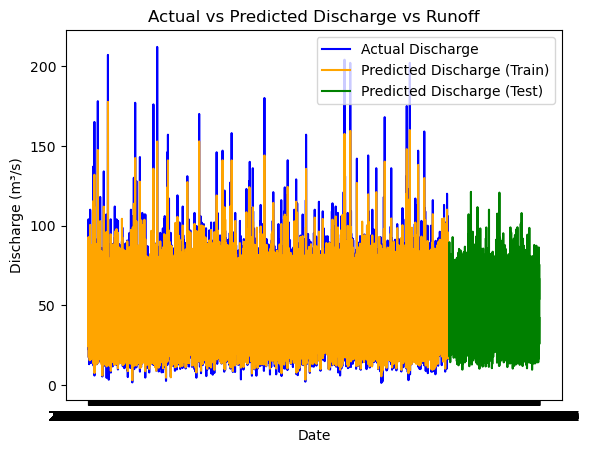

In [20]:
# Create a new figure
fig, ax = plt.subplots()

# Plot the actual discharge, the predicted discharge and the runoff
ax.plot(y_train.index, y_train, label='Actual Discharge', color='blue')
ax.plot(y_train.index, y_pred_train, label='Predicted Discharge (Train)', color='orange')
ax.plot(y_test.index, y_pred_test, label='Predicted Discharge (Test)', color='green')

# Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Discharge (m³/s)')
ax.set_title('Actual vs Predicted Discharge vs Runoff')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [36]:
# Convert the predictions to pandas series
y_pred_train = pd.Series(y_pred_train, index=y_train.index)
y_pred_test = pd.Series(y_pred_test, index=y_test.index)
runoff = pd.Series(runoff, index=y_train.index)
y_pred = pd.concat([y_pred_train, y_pred_test])
y_pred.sort_index(inplace=True)
y_train.sort_index(inplace=True)
runoff.sort_index(inplace=True)
y_train.index = pd.to_datetime(y_train.index)
y_pred.index = pd.to_datetime(y_pred.index)
runoff.index = pd.to_datetime(runoff.index)

In [39]:
# Create an output widget
out = widgets.Output()

def update_plot(date_range):
    start_date, end_date = date_range
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(y_train.loc[start_date:end_date], label='Actual Discharge', color='blue')
    ax.plot(y_pred.loc[start_date:end_date], label='Predicted Discharge', color='orange')
    ax.plot(runoff.loc[start_date:end_date], label='Hydro Discharge', color='green')
    ax.set_xlabel('Date')
    ax.set_ylabel('Discharge (m³/s)')
    ax.set_title('Actual vs Predicted Discharge')
    ax.legend()
    
    # Display the figure in the output widget and clear the old figure
    with out:
        clear_output(wait=True)
        display(fig)
    plt.close(fig)

# Create a date range slider
date_range_slider = widgets.SelectionRangeSlider(
    options=[pd.to_datetime(date).date() for date in pd.date_range(y_train.index.min(), y_train.index.max(), freq='D')],
    index=(0, len(y_train.index)-1),
    description='Date Range',
    orientation='horizontal',
    layout={'width': '500px'}
)

# Display the slider and the output widget
display(out)

# Update the plot when the slider value changes
widgets.interact(update_plot, date_range=date_range_slider)

Output()

interactive(children=(SelectionRangeSlider(description='Date Range', index=(0, 9933), layout=Layout(width='500…

<function __main__.update_plot(date_range)>

观测数据，发现predicted discharge在高值时候偏低，低值时候偏高，但是整体上还是比较接近的。这里可以修改罚函数，让模型更加关注高值的预测，因为这是我们关注的信息。


# 特定目标优化

## 样本权重

In [62]:
# Calculate the 90th percentile
percentile_90 = y_train.quantile(0.9)

# Set the threshold to the 90th percentile
threshold = percentile_90

# Calculate weights
weights = y_train.apply(lambda x: x if x > threshold else 1)

# Fit the model with weights
model.fit(X_train, y_train, sample_weight=weights)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print('Mean Squared Error:', mse)
print('R2 Score:', r2)

Mean Squared Error: 552.6901534214231
R2 Score: -0.030434061487471853


看起来你的模型在使用样本权重后的性能下降了，这可能是因为权重的设置并没有帮助模型更好地捕捉到高值，或者可能是因为权重的设置使得模型过于关注高值而忽视了其他的信息。

这里有一些可能的解决方案：

1. **调整权重的设置**：你可以尝试使用不同的方式来设置权重，例如，你可以尝试使用不同的阈值，或者你可以尝试使用不同的函数来计算权重。你也可以尝试使用一些更复杂的方法来设置权重，例如，你可以使用一些机器学习的技术来预测每个样本的重要性，然后用这个预测的重要性来设置权重。

2. **使用不同的模型**：随机森林可能不是最适合你的问题的模型。你可以尝试使用其他的模型，例如梯度提升树（Gradient Boosting Trees），这种模型允许我们自定义损失函数，因此可能更适合你的需求。

3. **使用不同的评价指标**：R²分数可能不是最适合你的问题的评价指标。如果你主要关心的是高值的预测，那么你可以考虑使用一些更关注高值的评价指标，例如平均绝对百分比误差（MAPE）或者分位数损失。

4. **数据预处理**：你可以尝试对你的数据进行一些预处理，以帮助模型更好地捕捉到高值。例如，你可以尝试对目标变量进行对数转换，或者你可以尝试添加一些新的特征，这些特征可能能够帮助模型更好地预测高值。

请注意，这些只是一些可能的解决方案，你可能需要尝试不同的方法，看看哪一种方法对你的问题最有效。

## 梯度提升树 (Gradient Boosting Tree)

梯度提升树（Gradient Boosting Trees）是一种强大的机器学习算法，特别适合处理回归和分类问题。它通过迭代地添加新的决策树，每一步都试图纠正前一步的预测错误，从而提高模型的预测性能。

In [6]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into features and target
features = df.drop(['discharge'], axis=1)
target = df['discharge']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Create a Gradient Boosting Regressor model
model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate the mean squared error and R2 score of the predictions
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print('Mean Squared Error:', mse)
print('R2 Score:', r2)

Mean Squared Error: 142.84258311270833
R2 Score: 0.7336846655236893


### 自定义损失函数

使用XGBoost或LightGBM，这两个库提供了更简单的方式来自定义损失函数。在这些库中，你只需要定义一个函数，该函数接受预测值和真实值作为输入，返回损失的梯度和二阶导数。

In [7]:
import xgboost as xgb
import numpy as np

# Define custom loss function
def custom_loss(y_pred, dtrain):
    y_true = dtrain.get_label()
    diff = y_true - y_pred
    grad = -2 * diff
    hess = 2 * np.ones_like(diff)
    return grad, hess

# Create a DMatrix from the training data
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define parameters
params = {
    'random_state': 42
}

# Train the model
model = xgb.train(params, dtrain, num_boost_round=100, obj=custom_loss)

# Make predictions on the test data
y_pred_train = model.predict(xgb.DMatrix(X_train))
y_pred_test = model.predict(xgb.DMatrix(X_test))


# Calculate the mean squared error and R2 score of the predictions
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print('Mean Squared Error:', mse)
print('R2 Score:', r2)

Mean Squared Error: 118.75561607784589
R2 Score: 0.778592343210726


In [7]:
# Convert the predictions to pandas series
y_pred_train = pd.Series(y_pred_train, index=y_train.index)
y_pred_test = pd.Series(y_pred_test, index=y_test.index)
runoff = pd.Series(runoff, index=y_train.index)
y_pred = pd.concat([y_pred_train, y_pred_test])
y_pred.sort_index(inplace=True)
y_train.sort_index(inplace=True)
runoff.sort_index(inplace=True)
y_train.index = pd.to_datetime(y_train.index)
y_pred.index = pd.to_datetime(y_pred.index)
runoff.index = pd.to_datetime(runoff.index)

In [8]:
# Create an output widget
out = widgets.Output()

def update_plot(date_range):
    start_date, end_date = date_range
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(y_train.loc[start_date:end_date], label='Actual Discharge', color='blue')
    ax.plot(y_pred.loc[start_date:end_date], label='Predicted Discharge', color='orange')
    ax.plot(runoff.loc[start_date:end_date], label='Hydro Discharge', color='green')
    ax.set_xlabel('Date')
    ax.set_ylabel('Discharge (m³/s)')
    ax.set_title('Actual vs Predicted Discharge')
    ax.legend()
    
    # Display the figure in the output widget and clear the old figure
    with out:
        clear_output(wait=True)
        display(fig)
    plt.close(fig)

# Create a date range slider
date_range_slider = widgets.SelectionRangeSlider(
    options=[pd.to_datetime(date).date() for date in pd.date_range(y_train.index.min(), y_train.index.max(), freq='D')],
    index=(0, len(y_train.index)-1),
    description='Date Range',
    orientation='horizontal',
    layout={'width': '500px'}
)

# Display the slider and the output widget
display(out)

# Update the plot when the slider value changes
widgets.interact(update_plot, date_range=date_range_slider)

Output()

interactive(children=(SelectionRangeSlider(description='Date Range', index=(0, 9933), layout=Layout(width='500…

<function __main__.update_plot(date_range)>

观察效果发现模型对高值的预测还是低估了，这是因为你的自定义损失函数是一个平方损失函数，它对所有的预测误差都是平等对待的。如果你想要模型对高值的预测更加准确，你可以尝试修改你的损失函数，让它对高值的预测误差给予更大的惩罚。

In [4]:
import xgboost as xgb
import numpy as np

# Define custom loss function
def custom_loss(y_pred, dtrain):
    y_true = dtrain.get_label()
    diff = y_true - y_pred
    grad = np.where(diff > 0, -2 * diff, -np.abs(diff))
    hess = np.where(diff > 0, 2 * np.ones_like(diff), np.ones_like(diff))
    return grad, hess

# Create a DMatrix from the training data
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define parameters
params = {
    'random_state': 42
}

# Train the model
model = xgb.train(params, dtrain, num_boost_round=100, obj=custom_loss)

# Make predictions on the test data
y_pred_train = model.predict(xgb.DMatrix(X_train))
y_pred_test = model.predict(xgb.DMatrix(X_test))


# Calculate the mean squared error and R2 score of the predictions
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print('Mean Squared Error:', mse)
print('R2 Score:', r2)

Mean Squared Error: 1.1247380663352674e+22
R2 Score: -2.0969586786173633e+19


通过实验发现自定义损失函数的效果并不好，可能是因为自定义损失函数的梯度和hessian矩阵的计算不太对，需要进一步研究。

# LSTM

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 2.9 K 
4 | V             | Linear           | 21    
---------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.023     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

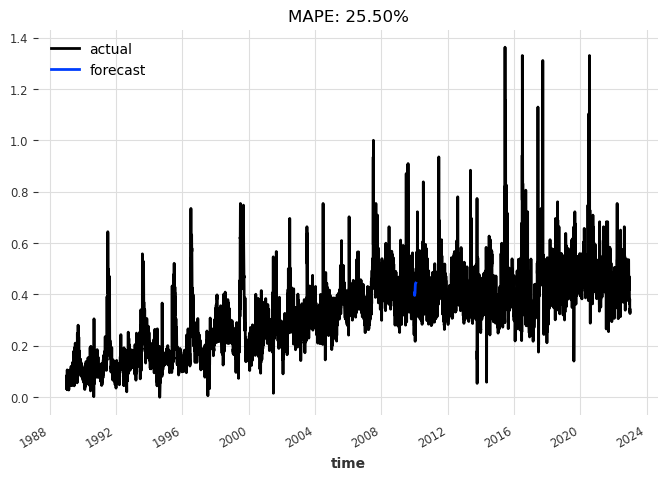

In [53]:
from darts import TimeSeries
from darts.models import RNNModel
from darts.dataprocessing.transformers import Scaler
from sklearn.metrics import mean_absolute_error
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape


# Convert DataFrame to TimeSeries
series = TimeSeries.from_dataframe(df.reset_index(), 'time', ['discharge'])

# Create training and validation sets
train, val = series.split_after(pd.Timestamp('2010-01-01'))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# create month and year covariate series
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), end='2023-12-31', freq=series.freq_str),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)
extended_covariates = year_series.stack(month_series)

my_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=50,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Discharge_LSTM",
    log_tensorboard=False,  # Disable logging
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    },   
    save_checkpoints=True,
)

my_model.fit(
    train_transformed,
    future_covariates=extended_covariates,
    val_series=val_transformed,
    val_future_covariates=extended_covariates,
    verbose=True,
)

def eval_model(model):
    pred_series = model.predict(n=26, future_covariates=extended_covariates)
    plt.figure(figsize=(8, 5))
    series_transformed.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_transformed)))

eval_model(my_model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

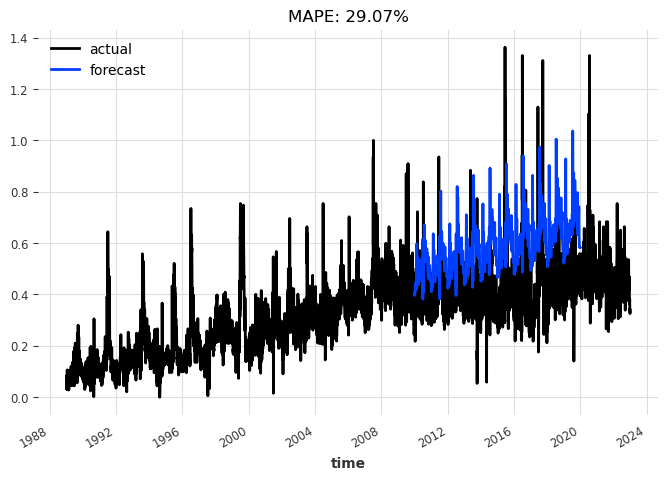

In [56]:
def eval_model(model):
    global pred_series
    pred_series = model.predict(n=365*10, future_covariates=extended_covariates)
    plt.figure(figsize=(8, 5))
    series_transformed.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_transformed)))

eval_model(my_model)

In [58]:
df.head()

,precip,runoff,T2M_MAX,T2M_MIN,RH2M,ALLSKY_SFC_SW_DWN,WS2M,PS,T2M,ETo_PM,ETo_HS,discharge
time,,,,,,,,,,,,
1989-01-01,0.0,0.018179,10.07,1.12,73.00,2.61,2.04,103.13,4.81,1.82,1.22,7.00
1989-01-02,0.0,0.036330,12.39,0.13,76.44,2.13,1.65,102.68,5.83,1.83,1.49,8.14
1989-01-03,0.0,0.054453,12.26,3.40,80.62,2.02,2.39,102.96,6.70,1.60,1.32,10.60
1989-01-04,0.0,0.072550,12.15,4.04,69.94,1.22,3.62,103.20,7.05,1.24,1.29,12.80
1989-01-05,0.9,0.090644,12.61,3.19,76.69,2.28,3.02,102.77,7.32,1.94,1.41,8.58


这是只考虑了时间序列的预测结果，下面我们来看看加入了气象数据还有水文模拟结果的预测结果。

## Covariates

In [80]:
# Convert DataFrame to TimeSeries
series = TimeSeries.from_dataframe(df.reset_index(), 'time', ['discharge'])

# Create training and validation sets
train, val = series.split_after(pd.Timestamp('2010-01-01'))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

# Create covariates for all other columns
covariates = [TimeSeries.from_dataframe(df.reset_index(), 'time', [col]) for col in df.columns if col != 'discharge']
covariates_transformed = [transformer.fit_transform(cov) for cov in covariates]

# Create month and year covariate series
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), end='2022-12-31', freq=series.freq_str),
    attribute="year",
    one_hot=False,
)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(
    year_series, attribute="month", one_hot=True
)

# Add year_series and month_series to the list of covariates
covariates_transformed.extend([year_series, month_series])

# Stack all covariates together
extended_covariates = covariates_transformed[0]
for cov in covariates_transformed[1:]:
    extended_covariates = extended_covariates.stack(cov)

my_model = RNNModel(
    model="LSTM",
    hidden_dim=10,
    dropout=0,
    batch_size=16,
    n_epochs=50,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Discharge_LSTM",
    log_tensorboard=False,  # Disable logging
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    },   
    save_checkpoints=True,
)

my_model.fit(
    train_transformed,
    future_covariates=extended_covariates,
    val_series=val_transformed,
    val_future_covariates=extended_covariates,
    verbose=True,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 1.5 K 
4 | V             | Linear           | 11    
---------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.012     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

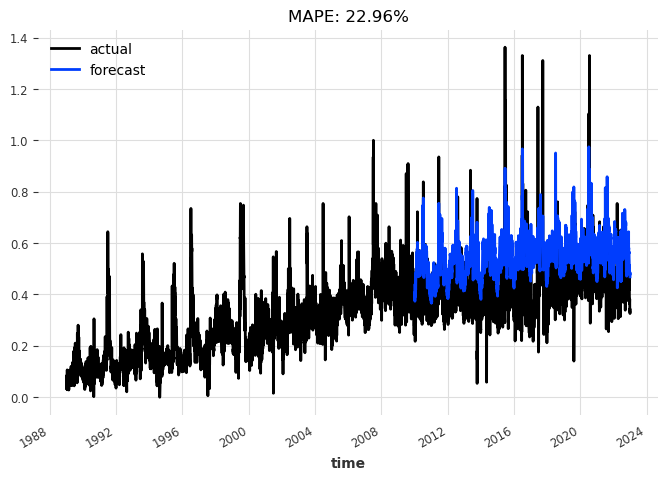

MSE: 0.02
R2 Score: -1.23


In [81]:
def eval_model(model):
    pred_series = model.predict(n=len(val_transformed), future_covariates=extended_covariates)
    plt.figure(figsize=(8, 5))
    series_transformed.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_transformed)))
    plt.show()

    # Calculate and print MSE
    mse = mean_squared_error(val_transformed.values()[:len(pred_series)], pred_series.values())
    print("MSE: {:.2f}".format(mse))

    # Calculate and print R2 score
    r2 = r2_score(val_transformed.values()[:len(pred_series)], pred_series.values())
    print("R2 Score: {:.2f}".format(r2))

eval_model(my_model)